# Objetivos 
#### Aumentar la conversion en la pagina web


# Cambios en la página de inicio del sitio web: 

- **$H0$**: Cambiar el diseño de la página de inicio no afectará las conversiones.
- **$H1$**: Cambiar el diseño de la página de inicio aumentará las conversiones.


# Dividir a los usuarios en control y test
- **grupo A** : experimentaría el diseño original de la página de inicio 
- **grupo B** : experimentaría el nuevo diseño

Luego, compararíamos las conversiones entre ambos grupos para determinar si el nuevo diseño tiene un impacto significativo.


# Decidir la métrica y la duración de la prueba
La métrica principal sería la tasa de conversión, que representa el porcentaje de usuarios que realizan una acción deseada en la página de inicio, como hacer una compra. Se compararía la tasa de conversión entre el grupo de control (diseño original) y el grupo de test (nuevo diseño).
Ademas comprobariamos donde afecta mejor el cambio, en que tipo de disposiutivo, la localidad, y la relacion entre el tiempo y paginas vista con la conversion



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
#import scypy.stats as stats
from itertools import combinations
import math
from src import soporte_abtesting as sa

# Calcular el tamaño muestral
# -----------------------------------------------------------------------
from statsmodels.stats.power import NormalIndPower
import statsmodels.stats.api as sms

# Configuración de las gráficas
# ------------------------------------------------------------------------------
# establece el estilo del fondo de las gráficas como "whitegrid". Las gráficas tendrán un fondo blanco con líneas de cuadrícula horizontales y verticales.
sns.set_style("dark")

# cambiará el esquema de colores predeterminado de Seaborn a uno más oscuro, adecuado para gráficas con fondos claros. 
sns.set_theme(style="dark")

# establece el estilo en seaborn-v0_8-darkgrid. 
plt.style.use('dark_background')

# Ignorar los warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("archive/ab_testing.csv")
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


In [3]:
sa.exploracion_dataframe(df, "Group")

El número de datos es 5000 y el de columnas es 7

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
User ID,int64
Group,object
Page Views,int64
Time Spent,int64
Conversion,object
Device,object
Location,object



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna GROUP tiene las siguientes valore únicos:


,count
Group,
A,2519
B,2481


La columna CONVERSION tiene las siguientes valore únicos:


,count
Conversion,
No,4515
Yes,485


La columna DEVICE tiene las siguientes valore únicos:


,count
Device,
Desktop,2538
Mobile,2462


La columna LOCATION tiene las siguientes valore únicos:


,count
Location,
Scotland,1281
England,1246
Northern Ireland,1242
Wales,1231



 ..................... 

Los principales estadísticos de las columnas categóricas para el B son: 


,count,unique,top,freq
Group,2481,1,B,2481
Conversion,2481,2,No,2132
Device,2481,2,Desktop,1294
Location,2481,4,England,640



 ..................... 

Los principales estadísticos de las columnas numéricas para el B son: 


,count,mean,std,min,25%,50%,75%,max
User ID,2481.0,14875.678356,2880.104515,10005.0,12367.0,14815.0,17309.0,19993.0
Page Views,2481.0,7.492946,3.963448,1.0,4.0,8.0,11.0,14.0
Time Spent,2481.0,243.303910,119.193552,40.0,136.0,244.0,348.0,449.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el A son: 


,count,unique,top,freq
Group,2519,1,A,2519
Conversion,2519,2,No,2383
Device,2519,2,Mobile,1275
Location,2519,4,Scotland,670



 ..................... 

Los principales estadísticos de las columnas numéricas para el A son: 


,count,mean,std,min,25%,50%,75%,max
User ID,2519.0,14973.893212,2858.061548,10001.0,12540.5,14902.0,17451.0,19995.0
Page Views,2519.0,7.581580,4.080066,1.0,4.0,8.0,11.0,14.0
Time Spent,2519.0,241.733227,117.340026,40.0,137.5,241.0,343.0,449.0


In [4]:
# calculamos el tamaño muestral teniendo en cuenta la TASA DE CONVERSIÓN
diferencia_conversion = sms.proportion_effectsize(0.05, 0.13)   

tamaño_muestral_conversion = sms.NormalIndPower().solve_power(
    diferencia_conversion,  # el tamaño del efecto calculado en el paso anterior
    power=0.8, # la potencia estadística deseada, que recordemos se suele establecer en 0.8
    alpha=0.05, # nivel de significancia deseado, que normalmente se establece en 0.05
    ratio=1 # La relación entre el tamaño de muestra del grupo experimental y el tamaño de muestra del grupo de control. En este caso, se establece en 1, lo que significa que ambos grupos tendrán el mismo tamaño de muestra.

    )                                              
                       
print(f'El tamaño muestral BASANDONOS EN LA TASA DE CONVERSIÓN DEBE SER DE: {math.ceil(tamaño_muestral_conversion)}')

El tamaño muestral BASANDONOS EN LA TASA DE CONVERSIÓN DEBE SER DE: 191


In [5]:
# ya tenemos los datos preparados, lo siguiente es seleccionar 191 usuarios de cada grupo

# seleccionamos 191 usuarios de cada grupo de forma aleatoria
grupo_control = df[df['Group'] == 'A'].sample(n=math.ceil(tamaño_muestral_conversion), random_state=22)
grupo_test = df[df['Group'] == 'B'].sample(n=math.ceil(tamaño_muestral_conversion), random_state=22)

# unimos los dos conjuntos de datos
ab_test = pd.concat([grupo_control, grupo_test], axis=0).reset_index(drop = True)

# comprobamos que tengamos el mismo número de usuarios en los 2 grupos
ab_test["Group"].value_counts()

Group
A    191
B    191
Name: count, dtype: int64

In [6]:
# Convertir "Yes"/"No" en valores numéricos para calcular la tasa de conversión
df["Conversion"] = df["Conversion"].map({"Yes": 1, "No": 0})

# Crear una copia del dataframe para evitar modificar el original
df_temp = df.copy()

# Calcular la tasa de conversión y desviación estándar por grupo
ratio_conversion = df_temp.groupby("Group")["Conversion"].agg(["mean", "std"]).round(4)

# Mostrar los datos
display(ratio_conversion)



,mean,std
Group,,
A,0.0540,0.2260
B,0.1407,0.3477


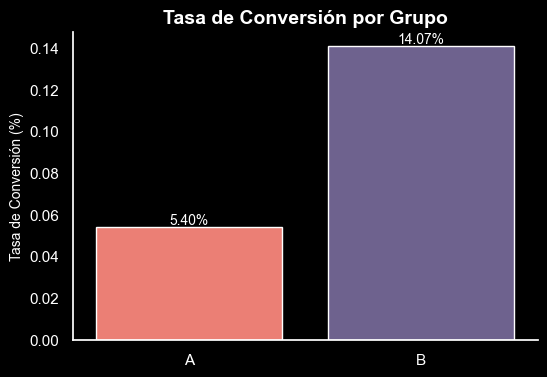

In [7]:
# Crear el gráfico de barras con barras de error
plt.figure(figsize=(6, 4))
fig = sns.barplot(
    data=ratio_conversion.reset_index(), 
    x="Group", 
    y="mean", 
    palette=["#FF6F61", "#6B5B95"], 
    errorbar="sd"
)

# Etiquetas en las barras (convertimos a porcentaje)
for container in fig.containers:
    fig.bar_label(container, labels=[f"{v * 100:.2f}%" for v in container.datavalues], fontsize=10)

# Eliminar bordes innecesarios
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)

# Títulos y etiquetas
fig.set_title("Tasa de Conversión por Grupo", fontsize=14, fontweight="bold")
fig.set_ylabel("Tasa de Conversión (%)", fontsize=10)
fig.set_xlabel("")  # Se deja vacío para un diseño más limpio

plt.show()

# Conclusion en conversiones
Podemos visualizar que existe un mayor grado de conversion con el nuevo diseño, por lo que se cumple la H1

# Analisis de conversiones positivas por Dispositivo y Localidad

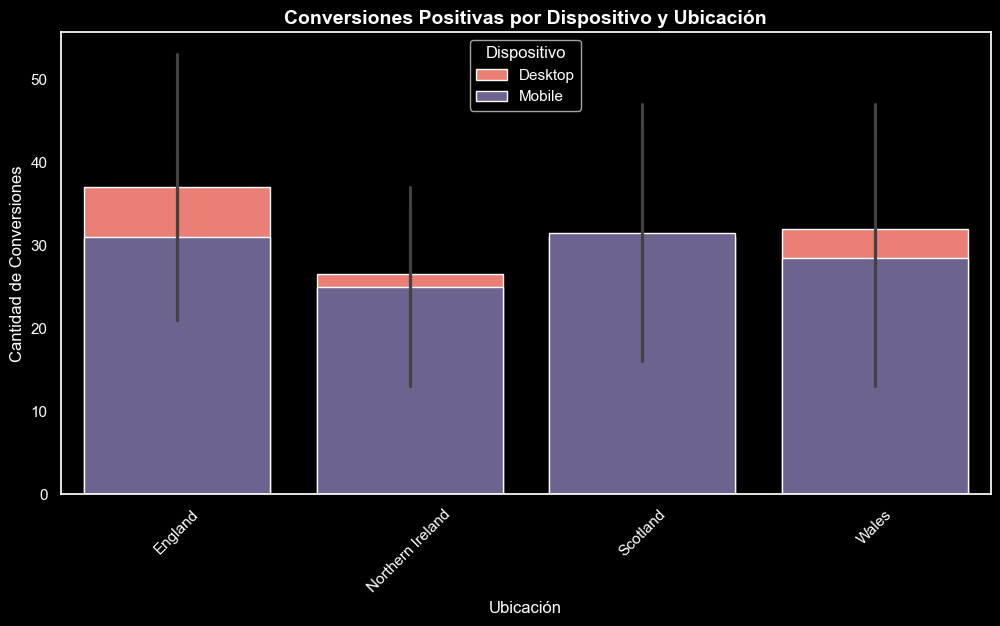

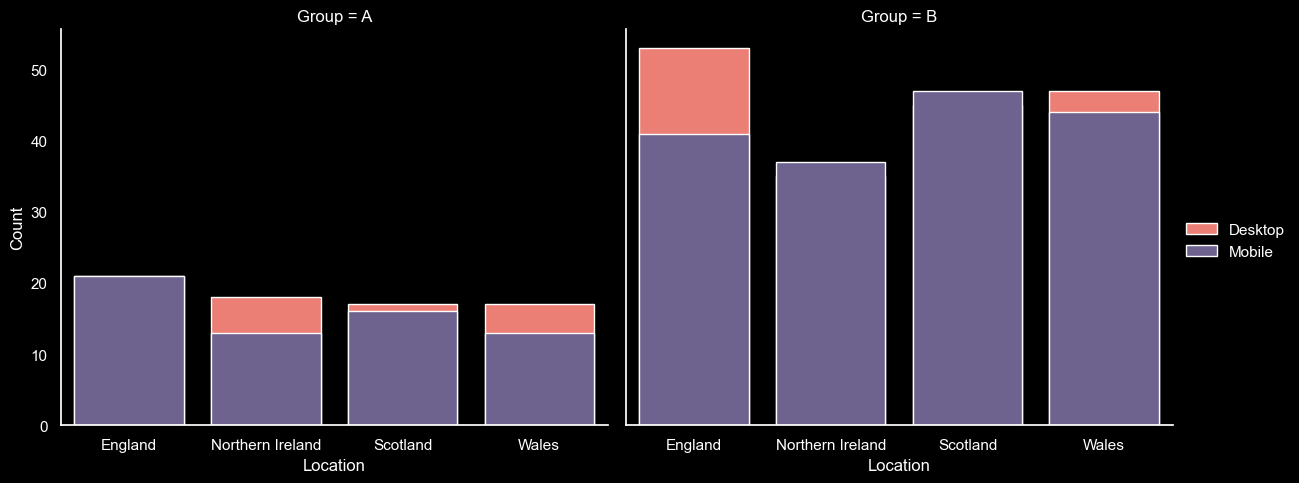

In [14]:

# Definir una paleta de colores más atractiva
colores = ["#FF6F61", "#6B5B95"]  # Mobile en rojo coral, Desktop en azul violeta

# Definir una paleta de colores más atractiva
colores = ["#FF6F61", "#6B5B95"]  # Mobile en rojo coral, Desktop en azul violeta

# Agrupar los datos sin modificar el dataframe original
conversiones_positivas = df[df["Conversion"] == 1].copy()
cuenta_agrupada = conversiones_positivas.groupby(["Group", "Device", "Location"])["Conversion"].count().reset_index(name="Count")

# Crear el gráfico de barras apiladas con nuevos colores
plt.figure(figsize=(12, 6))
sns.barplot(data=cuenta_agrupada, x="Location", y="Count", hue="Device", dodge=False, palette=colores)

# Añadir etiquetas y título
plt.xlabel("Ubicación")
plt.ylabel("Cantidad de Conversiones")
plt.title("Conversiones Positivas por Dispositivo y Ubicación", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)  # Mejorar legibilidad en el eje X
plt.legend(title="Dispositivo")

# Dividir los grupos A y B en gráficos separados manteniendo los mismos colores
g = sns.FacetGrid(cuenta_agrupada, col="Group", height=5, aspect=1.2)
g.map_dataframe(sns.barplot, x="Location", y="Count", hue="Device", dodge=False, palette=colores)
g.add_legend()

plt.show()



# Análisis clave:
- Las conversiones en Mobile son menores en algunas ubicaciones, destacándose Mobile-Northern Ireland y Mobile-Wales con los valores más bajos.
- En todas las regiones, Desktop tiene más conversiones que Mobile, aunque la diferencia varía según la ubicación.
- Inglaterra presenta la mayor diferencia entre dispositivos, con Desktop alcanzando valores significativamente más altos que Mobile.
- En Escocia y Gales, las conversiones en Desktop y Mobile son más equilibradas, lo que sugiere que en ciertas ubicaciones Mobile puede desempeñarse de manera más similar a Desktop.
- La relación entre conversiones en Mobile y Desktop varía según la ubicación, lo que podría estar influenciado por factores externos como hábitos de navegación o acceso a tecnología en cada región.

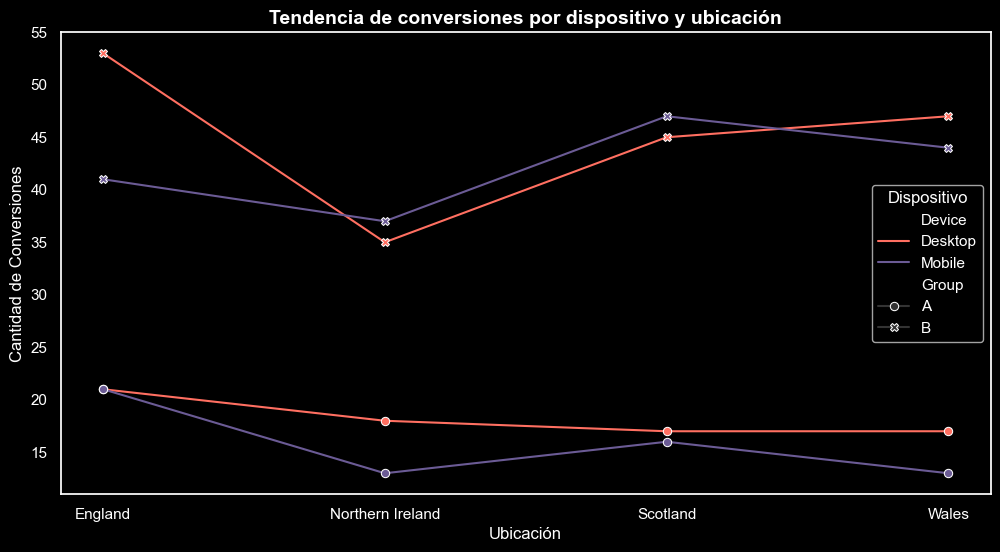

In [15]:
colores = ["#FF6F61", "#6B5B95"]


# Crear el gráfico de líneas en lugar de barras
plt.figure(figsize=(12, 6))
sns.lineplot(data=cuenta_agrupada, x="Location", y="Count", hue="Device", style="Group", markers=True, dashes=False,palette=colores)

# Ajustes visuales
plt.xlabel("Ubicación", fontsize=12)
plt.ylabel("Cantidad de Conversiones", fontsize=12)
plt.title("Tendencia de conversiones por dispositivo y ubicación", fontsize=14, fontweight='bold')
plt.legend(title="Dispositivo")

plt.show()

# Análisis Clave (Basado en el Gráfico de Líneas)

## 1. Variación en tendencias por dispositivo  
- En la mayoría de las ubicaciones, **Desktop mantiene una tendencia superior a Mobile**, con picos más altos en conversiones.  
- **Inglaterra destaca con la brecha más amplia entre Desktop y Mobile**, lo que indica una mayor preferencia por Desktop en esa región.  
- En **Escocia y Gales, las líneas de Mobile y Desktop están más cercanas**, lo que sugiere una distribución más equilibrada de conversiones entre dispositivos.  

## 2️. Diferencias de comportamiento entre ubicaciones  
- **Inglaterra muestra la tendencia más pronunciada**, con valores elevados en ambos dispositivos, pero con una diferencia notable a favor de Desktop.  
- **Irlanda del Norte presenta la tendencia más baja**, con menos conversiones en general y menor variabilidad entre dispositivos.  
- **Escocia y Gales siguen una tendencia similar**, con fluctuaciones menores entre Desktop y Mobile.  

## 3. Tendencias en Mobile  
- A pesar de que **Desktop domina en la mayoría de los casos**, en ciertas ubicaciones **Mobile muestra una tendencia más cercana**, lo que indica que su rendimiento puede depender del contexto local.  
- En algunas regiones, la diferencia entre Mobile y Desktop **no es constante**, sino que fluctúa a lo largo de las ubicaciones.  

---

# 🏁 Conclusión  
- **El gráfico de líneas revela tendencias más dinámicas**: en algunas regiones la diferencia entre dispositivos es más estable, mientras que en otras hay fluctuaciones más marcadas.  
- **Desktop sigue siendo el dispositivo con mayor cantidad de conversiones en todas las ubicaciones**, pero el desempeño de Mobile varía dependiendo del contexto geográfico.  
- **La variabilidad entre ubicaciones sugiere que factores como hábitos de navegación o accesibilidad tecnológica pueden influir en las conversiones.**  


# Z-test

In [17]:
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,0,Mobile,Northern Ireland
1,11682,A,9,342,0,Mobile,Scotland
2,19825,A,2,396,0,Desktop,Northern Ireland
3,16080,B,4,318,0,Desktop,Wales
4,18851,A,1,338,1,Desktop,Scotland


In [25]:
# instanciamos la clase de los métodos estadísticos
ab_testing = sa.Pruebas_parametricas("Group", "Conversion", df_temp, "B", "A")
ab_testing.z_test()

El estadístico de prueba (Z) es: -10.35, el p-valor es 0.0
El p-valor de la prueba es 0.0, por lo tanto, hay diferencias significativas entre los grupos.
